### Disciplined Convex Programming

https://dcp.stanford.edu/

https://dcp.stanford.edu/rules

https://www.cvxpy.org/tutorial/dcp/index.html#dcp

Disciplined convex programming (DCP) is a system for constructing mathematical expressions with known curvature from a given library of base functions. CVXPY uses DCP to ensure that the specified optimization problems are convex.

This section of the tutorial explains the rules of DCP and how they are applied by CVXPY.

Expressions
Expressions in CVXPY are formed from variables, parameters, numerical constants such as Python floats and Numpy matrices, the standard arithmetic operators +, -, *, /, @, and a library of functions ( https://www.cvxpy.org/tutorial/functions/index.html#functions ). Here are some examples of CVXPY expressions:

In [12]:
import cvxpy as cp
from cvxpy import *

print(cp.installed_solvers())

# Create variables and parameters.
x, y = cp.Variable(), cp.Variable()
a, b = cp.Parameter(), cp.Parameter()

# Examples of CVXPY expressions.
3.69 + b/3
x - 4*a
sqrt(x) - minimum(y, x - a)
maximum(2.66 - sqrt(y), square(x + 2*y))

['CLARABEL', 'DIFFCP', 'ECOS', 'ECOS_BB', 'OSQP', 'SCIPY', 'SCS']


Expression(CONVEX, NONNEGATIVE, ())

Expressions can be scalars, vectors, or matrices. The dimensions of an expression are stored as expr.shape. The total number of entries is given by expr.size, while the number of dimensions is given by expr.ndim. CVXPY will raise an exception if an expression is used in a way that doesn’t make sense given its dimensions, for example adding matrices of different size. The semantics for how shapes behave under arithmetic operations are the same as for NumPy ndarrays (except some broadcasting is banned).

In [4]:
import numpy

X = cp.Variable((5, 4))
A = numpy.ones((3, 5))

# Use expr.shape to get the dimensions.
print("dimensions of X:", X.shape)
print("size of X:", X.size)
print("number of dimensions:", X.ndim)
print("dimensions of sum(X):", cp.sum(X).shape)
print("dimensions of A @ X:", (A @ X).shape)

# ValueError raised for invalid dimensions.
try:
    A + X
except ValueError as e:
    print(e)

dimensions of X: (5, 4)
size of X: 20
number of dimensions: 2
dimensions of sum(X): ()
dimensions of A @ X: (3, 4)
Cannot broadcast dimensions  (3, 5) (5, 4)


CVXPY uses DCP analysis to determine the sign and curvature of each expression.

Sign
Each (sub)expression is flagged as positive (non-negative), negative (non-positive), zero, or unknown.

The signs of larger expressions are determined from the signs of their subexpressions. For example, the sign of the expression expr1*expr2 is

- Zero if either expression has sign zero.
- Positive if expr1 and expr2 have the same (known) sign.
- Negative if expr1 and expr2 have opposite (known) signs.
- Unknown if either expression has unknown sign.

The sign given to an expression is always correct. But DCP sign analysis may flag an expression as unknown sign when the sign could be figured out through more complex analysis. For instance, x*x is positive but has unknown sign by the rules above.

CVXPY determines the sign of constants by looking at their value. For scalar constants, this is straightforward. Vector and matrix constants with all positive (negative) entries are marked as positive (negative). Vector and matrix constants with both positive and negative entries are marked as unknown sign.

The sign of an expression is stored as expr.sign:

In [5]:
x = cp.Variable()
a = cp.Parameter(nonpos=True)
c = numpy.array([1, -1])

print("sign of x:", x.sign)
print("sign of a:", a.sign)
print("sign of square(x):", cp.square(x).sign)
print("sign of c*a:", (c*a).sign)

sign of x: UNKNOWN
sign of a: NONPOSITIVE
sign of square(x): NONNEGATIVE
sign of c*a: UNKNOWN


#### Curvature

Each (sub)expression is flagged as one of the following curvatures (with respect to its variables)
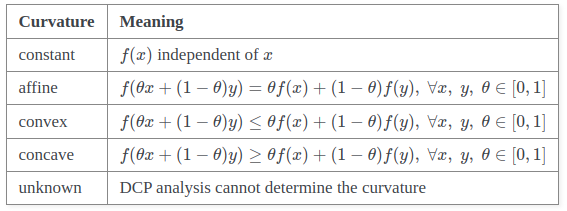
using the curvature rules given below. As with sign analysis, the conclusion is always correct, but the simple analysis can flag expressions as unknown even when they are convex or concave. Note that any constant expression is also affine, and any affine expression is convex and concave.

#### Curvature rules

DCP analysis is based on applying a general composition theorem from
convex analysis to each (sub)expression.

$ f(\text{expr}_1, \text{expr}_2, ..., \text{expr}_n) $ is convex if $ \text{ } f$
is a convex function and for each : $\text{expr}_{i}4$ one of the following
conditions holds:

-  $f$ is increasing in argument $i$ and $\text{expr}_{i}$ is convex.
-  $f$ is decreasing in argument $i$ and $\text{expr}_{i}$ is
   concave.
-  $\text{expr}_{i}$ is affine or constant.

$f(\text{expr}_1, \text{expr}_2, ..., \text{expr}_n)$ is concave if $\text{ } f$
is a concave function and for each $\text{expr}_{i}$ one of the following
conditions holds:

-  $f$ is increasing in argument $i$ and $\text{expr}_{i}$ is
   concave.
-  $f$ is decreasing in argument $i$ and $\text{expr}_{i}$ is convex.
-  $\text{expr}_{i}$ is affine or constant.

$f(\text{expr}_1, \text{expr}_2, ..., \text{expr}_n)$ is affine if $\text{ } f$
is an affine function and each $\text{expr}_{i}$ is affine.

If none of the three rules apply, the expression
$f(\text{expr}_1, \text{expr}_2, ..., \text{expr}_n)$ is marked as having unknown
curvature.

Whether a function is increasing or decreasing in an argument may depend
on the sign of the argument. For instance, ``square`` is increasing for
positive arguments and decreasing for negative arguments.

The curvature of an expression is stored as ``expr.curvature``:

In [6]:
x = cp.Variable()
a = cp.Parameter(nonneg=True)

print("curvature of x:", x.curvature)
print("curvature of a:", a.curvature)
print("curvature of square(x):", cp.square(x).curvature)
print("curvature of sqrt(x):", cp.sqrt(x).curvature)

curvature of x: AFFINE
curvature of a: CONSTANT
curvature of square(x): CONVEX
curvature of sqrt(x): CONCAVE


#### Infix operators

The infix operators ``+, -, *, /`` and matrix multiplication ``@``
are treated exactly like functions.
The infix operators ``+`` and ``-`` are affine, so the rules above are
used to flag the curvature. For example, ``expr1 + expr2`` is flagged as
convex if ``expr1`` and ``expr2`` are convex.

``expr1*expr2``, ``expr1/expr2``, and ``expr1@expr2``
can only be DCP when one of the expressions is constant.
The curvature rules above apply. For example, ``expr1/expr2`` is convex when
``expr1`` is concave and ``expr2`` is negative and constant.

#### Example 1

DCP analysis breaks expressions down into subexpressions. The tree
visualization below shows how this works for the expression
``2*square(x) + 3``. Each subexpression is shown in a blue box. We mark
its curvature on the left and its sign on the right.

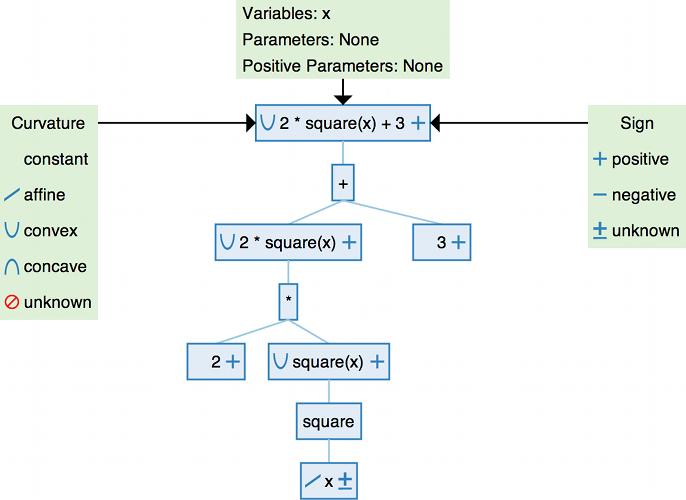

#### Example 2

We'll walk through the application of the DCP rules to the expression
``sqrt(1 + square(x))``.

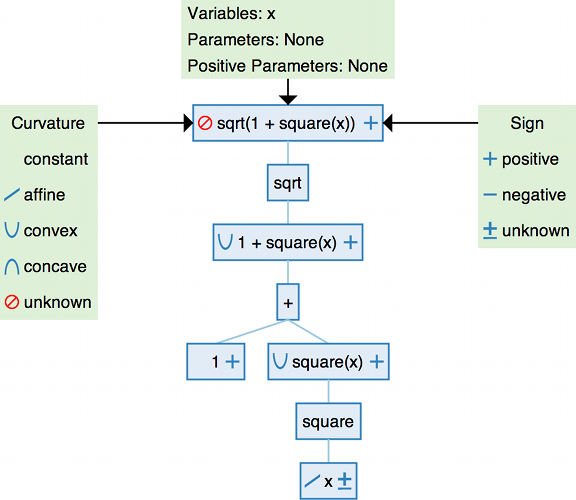


The variable ``x`` has affine curvature and unknown sign. The ``square``
function is convex and non-monotone for arguments of unknown sign. It
can take the affine expression ``x`` as an argument; the result
``square(x)`` is convex.

The arithmetic operator ``+`` is affine and increasing, so the
composition ``1 + square(x)`` is convex by the curvature rule for convex
functions. The function ``sqrt`` is concave and increasing, which means
it can only take a concave argument. Since ``1 + square(x)`` is convex,
``sqrt(1 + square(x))`` violates the DCP rules and cannot be verified as
convex.

In fact, ``sqrt(1 + square(x))`` is a convex function of ``x``, but the
DCP rules are not able to verify convexity. If the expression is written
as ``norm(hstack(1, x), 2)``, the L2 norm of the vector :math:`[1,x]`,
which has the same value as ``sqrt(1 + square(x))``, then it will be
certified as convex using the DCP rules.


In [7]:
print("sqrt(1 + square(x)) curvature:",
      cp.sqrt(1 + cp.square(x)).curvature)
print("norm(hstack([1, x]), 2) curvature:",
      cp.norm(cp.hstack([1, x]), 2).curvature)

sqrt(1 + square(x)) curvature: QUASICONVEX
norm(hstack([1, x]), 2) curvature: CONVEX


DCP problems
------------

A problem is constructed from an objective and a list of constraints. If
a problem follows the DCP rules, it is guaranteed to be convex and
solvable by CVXPY. The DCP rules require that the problem objective have
one of two forms:

-  Minimize(convex)
-  Maximize(concave)

The only valid constraints under the DCP rules are

-  affine == affine
-  convex <= concave
-  concave >= convex

You can check that a problem, constraint, or objective satisfies the DCP
rules by calling ``object.is_dcp()``. Here are some examples of DCP and
non-DCP problems:


In [8]:
x = cp.Variable()
y = cp.Variable()

# DCP problems.
prob1 = cp.Problem(cp.Minimize(cp.square(x - y)),
                    [x + y >= 0])
prob2 = cp.Problem(cp.Maximize(cp.sqrt(x - y)),
                [2*x - 3 == y,
                 cp.square(x) <= 2])

print("prob1 is DCP:", prob1.is_dcp())
print("prob2 is DCP:", prob2.is_dcp())

# Non-DCP problems.

# A non-DCP objective.
obj = cp.Maximize(cp.square(x))
prob3 = cp.Problem(obj)

print("prob3 is DCP:", prob3.is_dcp())
print("Maximize(square(x)) is DCP:", obj.is_dcp())

# A non-DCP constraint.
prob4 = cp.Problem(cp.Minimize(cp.square(x)),
                    [cp.sqrt(x) <= 2])

print(f"prob4 is DCP: {prob4.is_dcp()}")
print(f"sqrt(x) <= 2 is DCP: {(cp.sqrt(x) <= 2).is_dcp()}")

prob1 is DCP: True
prob2 is DCP: True
prob3 is DCP: False
Maximize(square(x)) is DCP: False
prob4 is DCP: False
sqrt(x) <= 2 is DCP: False


CVXPY will raise an exception if you call problem.solve() on a non-DCP problem.

In [9]:
# A non-DCP problem.
prob = cp.Problem(cp.Minimize(cp.sqrt(x)))

try:
    prob.solve()
except Exception as e:
    print(e)

Problem does not follow DCP rules. Specifically:
The objective is not DCP, even though each sub-expression is.
You are trying to minimize a function that is concave.
However, the problem does follow DQCP rules. Consider calling solve() with `qcp=True`.
